In [3]:
import numpy as np
import pandas as pd
import cv2
import os
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, DenseNet121
import tensorflow as tf
import psutil
from pympler import asizeof
import sklearn

In [2]:
csv_file_path = '../DL_for_Hin_Chest_X_Ray/Data_Entry_2017_filtered_2.csv'
# csv_file_path = '../DL_for_Hin_Chest_X_Ray/HIN_archive/Data_Entry_2017.csv'
df = pd.read_csv(csv_file_path)

IMAGE_DIR = "../DL_for_Hin_Chest_X_Ray/HIN_archive/images/"
ALL_LABELS = sorted(df["Finding Labels"].str.split("|").explode().unique())
ALL_LABELS_WITHOUT_NO = [l for l in ALL_LABELS if l != "No Finding"]
NUMBER_CLASSES = len(ALL_LABELS)

def preprocess_image(file_path, image_size):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    image = cv2.resize(image, (image_size, image_size))
    return image

def prepare_data(df, image_size, image_dir=IMAGE_DIR):
    images = []
    labels = []
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        image_path = os.path.join(image_dir, row["Image Index"])
        image = preprocess_image(image_path, image_size)
        
        if image is not None:
            images.append(image)

            current_label = np.zeros(NUMBER_CLASSES, dtype=int)
        
            if row["Finding Labels"] != "No Finding":
                indices = [i for i, label in enumerate(ALL_LABELS_WITHOUT_NO) if label in sorted(row["Finding Labels"].split("|"))]
                for idx in indices:
                    if 0 <= idx < NUMBER_CLASSES:
                        current_label[idx] = 1
            else:
                current_label[NUMBER_CLASSES - 1] = 1
            labels.append(current_label)
    
    images = np.array(images).reshape(-1, image_size, image_size)
    images = np.repeat(images[..., np.newaxis], 3, axis=-1) #rgb
    
    labels = np.array(labels)
    
    return images, labels

def prepare_data_as_paper(df, image_size, image_dir=IMAGE_DIR):
    images = []
    labels = []
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        image_path = os.path.join(image_dir, row["Image Index"])
        image = preprocess_image(image_path, image_size)
        
        if image is not None:
            images.append(image)

            current_label = np.zeros(NUMBER_CLASSES - 1, dtype=int)
        
            if row["Finding Labels"] != "No Finding":
                indices = [i for i, label in enumerate(ALL_LABELS_WITHOUT_NO) if label in sorted(row["Finding Labels"].split("|"))]
                for idx in indices:
                    if 0 <= idx < NUMBER_CLASSES:
                        current_label[idx] = 1
            labels.append(current_label)
    
    images = np.array(images).reshape(-1, image_size, image_size)
    images = np.repeat(images[..., np.newaxis], 3, axis=-1) #rgb
    
    labels = np.array(labels)
    
    return images, labels

In [ ]:
def weighted_cross_entropy(y_true, y_pred):
    p = tf.reduce_sum(y_true)
    n = tf.cast(tf.size(y_true), tf.float32) - p
    beta_p = (p + n) / (p + 1e-7)
    beta_n = (p + n) / (n + 1e-7)
    loss = -beta_p * y_true * tf.math.log(y_pred + 1e-7) - beta_n * (1 - y_true) * tf.math.log(1 - y_pred + 1e-7) # Add epsilon to avoid log(0)
    return tf.reduce_mean(loss)

In [ ]:
def weighted_cross_entropy2(y_true, y_pred):
    tf.print("y_true", y_true, summarize=-1)
    tf.print("y_pred", y_pred, summarize=-1)

    positive_cases = tf.equal(y_true[:, -1], 0)  # Positive when last column is 0
    negative_cases = tf.equal(y_true[:, -1], 1)  # Negative when last column is 1
    positive_cases = tf.cast(positive_cases, tf.float32)
    negative_cases = tf.cast(negative_cases, tf.float32)
    
    tf.print("positive_cases", positive_cases, summarize=-1)
    tf.print("negative_cases", negative_cases, summarize=-1)
    
    count_positive = tf.reduce_sum(positive_cases)
    count_negative = tf.reduce_sum(negative_cases)
    
    tf.print("count_positive", count_positive, summarize=-1)
    tf.print("count_negative", count_negative, summarize=-1)
    
    total_samples = tf.cast(tf.shape(y_true)[0], tf.float32)
    
    tf.print("total_samples", total_samples)

    beta_p = total_samples / count_positive
    beta_n = total_samples / count_negative
    
    beta_p = tf.clip_by_value(beta_p, 1e-7, 1e7) #  Clipping 
    beta_n = tf.clip_by_value(beta_n, 1e-7, 1e7)
    
    tf.print("beta_p", beta_p, summarize=-1)
    tf.print("beta_n", beta_n, summarize=-1)
    
    y_pred_binary = tf.stack([tf.reduce_sum(y_pred[:, :-1], axis=-1), y_pred[:, -1]], axis=-1)

    
    y_pred_binary = tf.cast(y_pred_binary, tf.float32)

    tf.print("y_pred_binary", y_pred_binary, summarize=-1)
    
    weighted_positive_loss = beta_p * tf.reduce_sum(-positive_cases * tf.math.log(y_pred_binary[:, 0] + 1e-7))
    weighted_negative_loss = beta_n * tf.reduce_sum(-negative_cases * tf.math.log(y_pred_binary[:, 1] + 1e-7))
    
    tf.print("weighted_positive_loss", weighted_positive_loss, summarize=-1)
    tf.print("weighted_negative_loss", weighted_negative_loss, summarize=-1)   
    
    return weighted_positive_loss + weighted_negative_loss

In [3]:
def create_resnet_model(image_size):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [4]:
def normalize_image(img, label):
    img = tf.cast(img, np.float32) / 255.0
    return img, label

def create_train_dataset(images_train, labels_train, batch_size=16):
    train_dataset = tf.data.Dataset.from_tensor_slices((images_train, labels_train))
    train_dataset = train_dataset.map(normalize_image)
    train_dataset = train_dataset.shuffle(buffer_size=100)
    train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
    train_dataset = train_dataset.repeat()
    return train_dataset

def create_val_dataset(images_val, labels_val, batch_size=16):
    val_dataset = tf.data.Dataset.from_tensor_slices((images_val, labels_val))
    val_dataset = val_dataset.map(normalize_image)
    val_dataset = val_dataset.batch(batch_size, drop_remainder=False)
    return val_dataset

In [6]:
def evaluate_model(model, images_test, labels_test, batch_size=16):

    images_test = tf.cast(images_test, np.float32) / 255.0
    
    predictions = model.predict(images_test, batch_size=batch_size)
    
    auc_per_class = []
    
    for class_idx in range(NUMBER_CLASSES):
        true_labels_class = labels_test[:, class_idx]
        
        auc = sklearn.metrics.roc_auc_score(true_labels_class, predictions[:, class_idx])
        auc_per_class.append(auc)
        
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels_test, axis=1)
    balanced_accuracy = sklearn.metrics.balanced_accuracy_score(true_classes, predicted_classes)
    accuracy = sklearn.metrics.accuracy_score(true_classes, predicted_classes)
    
    return auc_per_class, balanced_accuracy, accuracy

In [ ]:
NUMBER_OF_IMAGES = 1000
IMAGE_SIZE = 1024
BATCH_SIZE = 16

images, labels = prepare_data(df[:NUMBER_OF_IMAGES], IMAGE_SIZE)
images_train, images_val, labels_train, labels_val = sklearn.model_selection.train_test_split(images, labels, random_state=42, test_size=0.2)
images_test, labels_test = prepare_data(df[-(int(NUMBER_OF_IMAGES / 5)):], IMAGE_SIZE)

train_dataset = create_train_dataset(images_train, labels_train)

val_dataset = create_val_dataset(images_val, labels_val)

In [ ]:
model = create_resnet_model(IMAGE_SIZE)

steps_per_epoch = len(images_train) // BATCH_SIZE
validation_steps = len(images_val) // BATCH_SIZE

# class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels_train.argmax(axis=1)), y=labels_train.argmax(axis=1))
# class_weights = {i: class_weights[i] for i in range(len(class_weights))}

model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

In [ ]:
# Resolution

BATCH_SIZE = 16
NUMBER_OF_IMAGES = 1000
evaluations = {}

for ev_image_size in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
    
    images, labels = prepare_data(df[:NUMBER_OF_IMAGES], ev_image_size)
    images_train, images_val, labels_train, labels_val = sklearn.model_selection.train_test_split(images, labels, random_state=42, test_size=0.2)
    images_test, labels_test = prepare_data(df[-(int(NUMBER_OF_IMAGES / 5)):], ev_image_size)
    
    train_dataset = create_train_dataset(images_train,labels_train)
    val_dataset = create_val_dataset(images_val, labels_val)
    
    model = create_resnet_model(ev_image_size)
    
    steps_per_epoch = len(images_train) // BATCH_SIZE
    validation_steps = len(images_val) // BATCH_SIZE

    model.fit(
        train_dataset,
        steps_per_epoch=steps_per_epoch,
        epochs=20,
        validation_data=val_dataset,
        validation_steps=validation_steps,
        batch_size=BATCH_SIZE,
        verbose=1
    )
    evals = evaluate_model(model, images_test, labels_test)
    
    evaluations[ev_image_size] = evals
    print(f'\n{evals}\n')
    
print(evaluations)

In [ ]:
with open("pickles/resolution_1000samples.pkl", "wb") as file:
    pickle.dump(evaluations, file)

In [ ]:
plt.figure(figsize=(8, 6))

aucs = [evalu[0] for evalu in evaluations.values()]
aucs_at = [evalu[0] for evalu in aucs]
aucs_ef = [evalu[1] for evalu in aucs]
aucs_in = [evalu[2] for evalu in aucs]
aucs_nf = [evalu[3] for evalu in aucs]
baccs = [evalu[1] for evalu in evaluations.values()]
accs = [evalu[2] for evalu in evaluations.values()]

x_values = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

font_size = 16

plt.plot(x_values, accs, label="Accuracy")
plt.plot(x_values, baccs, label="Balanced Accuracy")

# plt.plot(x_values, aucs_at, label="Atelectasis")
# plt.plot(x_values, aucs_ef, label="Effusion")
# plt.plot(x_values, aucs_in, label="Infiltration")
# plt.plot(x_values, aucs_nf, label="No Finding")

plt.xlabel("Resolution in pixels x pixels", fontsize=font_size)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.legend(fontsize=font_size, loc="center left")

plt.savefig("evals/chestxray8/resolution_accsBaccs_1000_samples.pdf", bbox_inches='tight', pad_inches=0)

plt.show()

All labels: 10000 samples, 50 epochs: 
[0.6692994173103355, 0.5939930395255514, 0.6683094818155433, 0.5533819389301956, 0.6756526600600586, 0.5141695372704997, 0.5874413145539906, 0.814388249040227, 0.6113292270077111, 0.5362483786464559, 0.5052575717787114, 0.39618781165543754, 0.4708606350806452, 0.5637999231950844]

In [ ]:
# Resolution for multiple runs

BATCH_SIZE = 16
NUMBER_OF_IMAGES = 10000
evaluations = {}

for ev_image_size in [100, 200, 224, 300, 400, 500, 768, 1024]:
    
    evals_per_size = []

    for i in range(5):     
        
        tf.keras.backend.clear_session()
        
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        
        images, labels = prepare_data(df[:NUMBER_OF_IMAGES], ev_image_size)
        images_train, images_val, labels_train, labels_val = sklearn.model_selection.train_test_split(images, labels, random_state=42, test_size=0.2)
        images_test, labels_test = prepare_data(df[-(int(NUMBER_OF_IMAGES / 5)):], ev_image_size)
        
        train_dataset = create_train_dataset(images_train, labels_train)
        val_dataset = create_val_dataset(images_val, labels_val)
        
        steps_per_epoch = len(images_train) // BATCH_SIZE
        validation_steps = len(images_val) // BATCH_SIZE
        
        model = create_resnet_model(ev_image_size)
                
        model.fit(
            train_dataset,
            steps_per_epoch=steps_per_epoch,
            epochs=20,
            validation_data=val_dataset,
            validation_steps=validation_steps,
            batch_size=BATCH_SIZE,
            verbose=1)
        
        evals = evaluate_model(model, images_test, labels_test)
        evals_per_size.append(evals)
        
    evaluations[ev_image_size] = evals_per_size
    print(f'\n{evals_per_size}\n')
    
print(evaluations)

100%|██████████| 2000/2000 [00:27<00:00, 71.61it/s]
2025-03-02 22:11:02.178120: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-03-02 22:11:02.178157: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-02 22:11:02.178166: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-02 22:11:02.178184: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-02 22:11:02.178197: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/20


2025-03-02 22:11:04.541193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 52ms/step - auc: 0.5198 - loss: 1.1863 - val_auc: 0.6045 - val_loss: 0.9513
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - auc: 0.5606 - loss: 0.9618 - val_auc: 0.6060 - val_loss: 0.9461
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - auc: 0.5688 - loss: 0.9551 - val_auc: 0.6105 - val_loss: 0.9511
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - auc: 0.5860 - loss: 0.9492 - val_auc: 0.6146 - val_loss: 0.9515
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - auc: 0.5930 - loss: 0.9454 - val_auc: 0.6201 - val_loss: 0.9410
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - auc: 0.6027 - loss: 0.9418 - val_auc: 0.6228 - val_loss: 0.9417
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - auc: 0.6037 - loss: 0.9410 - val_auc: 0.6252 - val_loss: 0.9336
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - auc: 0.6197 - loss: 0.9337 - val_auc: 0.6260 - val_loss: 0.9332
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/st

100%|██████████| 2000/2000 [00:25<00:00, 79.27it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 54ms/step - auc: 0.5049 - loss: 1.2142 - val_auc: 0.6016 - val_loss: 0.9464
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - auc: 0.5444 - loss: 0.9572 - val_auc: 0.6026 - val_loss: 0.9431
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 51ms/step - auc: 0.5613 - loss: 0.9491 - val_auc: 0.6079 - val_loss: 0.9483
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - auc: 0.5700 - loss: 0.9439 - val_auc: 0.6090 - val_loss: 0.9435
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - auc: 0.5917 - loss: 0.9366 - val_auc: 0.6130 - val_loss: 0.9349
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 51ms/step - auc: 0.5878 - loss: 0.9387 - val_auc: 0.6169 - val_loss: 0.9347
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - auc: 0.5956 - loss: 0.9328 - val_auc: 0.6212 - val_loss: 0.9322
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - auc: 0.6058 - loss: 0.9292 - val_auc: 0.6237 - val_loss: 0.9277
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 

100%|██████████| 2000/2000 [00:25<00:00, 78.84it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 55ms/step - auc: 0.5268 - loss: 1.1848 - val_auc: 0.5961 - val_loss: 0.9448
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 51ms/step - auc: 0.5604 - loss: 0.9426 - val_auc: 0.6011 - val_loss: 0.9432
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - auc: 0.5790 - loss: 0.9351 - val_auc: 0.6045 - val_loss: 0.9444
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 51ms/step - auc: 0.5801 - loss: 0.9356 - val_auc: 0.6064 - val_loss: 0.9394
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 51ms/step - auc: 0.5922 - loss: 0.9299 - val_auc: 0.6088 - val_loss: 0.9380
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - auc: 0.6023 - loss: 0.9254 - val_auc: 0.6118 - val_loss: 0.9354
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - auc: 0.5997 - loss: 0.9264 - val_auc: 0.6150 - val_loss: 0.9343
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - auc: 0.6110 - loss: 0.9205 - val_auc: 0.6160 - val_loss: 0.9331
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 

100%|██████████| 2000/2000 [00:26<00:00, 76.41it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 56ms/step - auc: 0.4971 - loss: 1.1478 - val_auc: 0.5931 - val_loss: 0.9726
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 51ms/step - auc: 0.5463 - loss: 0.9161 - val_auc: 0.5959 - val_loss: 0.9487
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - auc: 0.5601 - loss: 0.9095 - val_auc: 0.5989 - val_loss: 0.9430
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 51ms/step - auc: 0.5806 - loss: 0.9058 - val_auc: 0.6003 - val_loss: 0.9426
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - auc: 0.5854 - loss: 0.9039 - val_auc: 0.6026 - val_loss: 0.9403
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 51ms/step - auc: 0.5960 - loss: 0.9004 - val_auc: 0.6069 - val_loss: 0.9383
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - auc: 0.6035 - loss: 0.9009 - val_auc: 0.6110 - val_loss: 0.9370
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 51ms/step - auc: 0.5977 - loss: 0.9024 - val_auc: 0.6114 - val_loss: 0.9375
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 

100%|██████████| 2000/2000 [00:26<00:00, 76.30it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 56ms/step - auc: 0.5156 - loss: 1.1805 - val_auc: 0.5797 - val_loss: 0.9846
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - auc: 0.5483 - loss: 0.9461 - val_auc: 0.5861 - val_loss: 0.9418
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 51ms/step - auc: 0.5769 - loss: 0.9306 - val_auc: 0.5882 - val_loss: 0.9402
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - auc: 0.5885 - loss: 0.9297 - val_auc: 0.5912 - val_loss: 0.9399
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - auc: 0.5918 - loss: 0.9264 - val_auc: 0.5945 - val_loss: 0.9349
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - auc: 0.5996 - loss: 0.9240 - val_auc: 0.5955 - val_loss: 0.9401
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 51ms/step - auc: 0.5951 - loss: 0.9247 - val_auc: 0.5951 - val_loss: 0.9459
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - auc: 0.5944 - loss: 0.9229 - val_auc: 0.6011 - val_loss: 0.9328
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 

100%|██████████| 2000/2000 [00:26<00:00, 76.51it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 57s 105ms/step - auc: 0.4986 - loss: 1.1575 - val_auc: 0.5697 - val_loss: 0.9635
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 101ms/step - auc: 0.5100 - loss: 0.9540 - val_auc: 0.5703 - val_loss: 0.9631
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 101ms/step - auc: 0.5183 - loss: 0.9494 - val_auc: 0.5770 - val_loss: 0.9562
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 101ms/step - auc: 0.5235 - loss: 0.9450 - val_auc: 0.5895 - val_loss: 0.9551
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 101ms/step - auc: 0.5354 - loss: 0.9477 - val_auc: 0.5844 - val_loss: 0.9523
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 101ms/step - auc: 0.5387 - loss: 0.9426 - val_auc: 0.5849 - val_loss: 0.9520
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 101ms/step - auc: 0.5495 - loss: 0.9392 - val_auc: 0.5921 - val_loss: 0.9609
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 101ms/step - auc: 0.5540 - loss: 0.9376 - val_auc: 0.5907 - val_loss: 0.9489
Epoch 9/20
500/500 ━━━━━━━━━━━━━

100%|██████████| 2000/2000 [00:26<00:00, 74.13it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 57s 107ms/step - auc: 0.5022 - loss: 1.1926 - val_auc: 0.5462 - val_loss: 0.9498
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 53s 106ms/step - auc: 0.5062 - loss: 0.9618 - val_auc: 0.5579 - val_loss: 0.9326
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 101ms/step - auc: 0.5102 - loss: 0.9604 - val_auc: 0.5732 - val_loss: 0.9346
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 101ms/step - auc: 0.5183 - loss: 0.9612 - val_auc: 0.5705 - val_loss: 0.9316
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 101ms/step - auc: 0.5264 - loss: 0.9615 - val_auc: 0.5728 - val_loss: 0.9380
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 101ms/step - auc: 0.5242 - loss: 0.9577 - val_auc: 0.5709 - val_loss: 0.9359
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 101ms/step - auc: 0.5394 - loss: 0.9572 - val_auc: 0.5748 - val_loss: 0.9334
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 101ms/step - auc: 0.5513 - loss: 0.9522 - val_auc: 0.5751 - val_loss: 0.9304
Epoch 9/20
500/500 ━━━━━━━━━━━━━

100%|██████████| 2000/2000 [00:26<00:00, 76.78it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 57s 106ms/step - auc: 0.4975 - loss: 1.1339 - val_auc: 0.5891 - val_loss: 0.9707
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 101ms/step - auc: 0.5092 - loss: 0.9547 - val_auc: 0.5931 - val_loss: 0.9695
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 101ms/step - auc: 0.5249 - loss: 0.9510 - val_auc: 0.5989 - val_loss: 0.9726
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 102ms/step - auc: 0.5132 - loss: 0.9553 - val_auc: 0.6097 - val_loss: 0.9708
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 102ms/step - auc: 0.5265 - loss: 0.9511 - val_auc: 0.6071 - val_loss: 0.9706
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 101ms/step - auc: 0.5426 - loss: 0.9470 - val_auc: 0.6118 - val_loss: 0.9642
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 101ms/step - auc: 0.5482 - loss: 0.9496 - val_auc: 0.6168 - val_loss: 0.9623
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 101ms/step - auc: 0.5550 - loss: 0.9417 - val_auc: 0.6214 - val_loss: 0.9637
Epoch 9/20
500/500 ━━━━━━━━━━━━━

100%|██████████| 2000/2000 [00:25<00:00, 78.06it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 57s 106ms/step - auc: 0.5121 - loss: 1.1195 - val_auc: 0.5747 - val_loss: 0.9632
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 101ms/step - auc: 0.5007 - loss: 0.9683 - val_auc: 0.5807 - val_loss: 0.9546
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 101ms/step - auc: 0.5166 - loss: 0.9646 - val_auc: 0.5890 - val_loss: 0.9507
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 101ms/step - auc: 0.5288 - loss: 0.9604 - val_auc: 0.5900 - val_loss: 0.9540
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 101ms/step - auc: 0.5310 - loss: 0.9627 - val_auc: 0.5881 - val_loss: 0.9563
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 101ms/step - auc: 0.5390 - loss: 0.9559 - val_auc: 0.5927 - val_loss: 0.9511
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 101ms/step - auc: 0.5514 - loss: 0.9556 - val_auc: 0.5963 - val_loss: 0.9451
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 101ms/step - auc: 0.5609 - loss: 0.9531 - val_auc: 0.5980 - val_loss: 0.9462
Epoch 9/20
500/500 ━━━━━━━━━━━━━

100%|██████████| 2000/2000 [00:26<00:00, 75.95it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 57s 106ms/step - auc: 0.4868 - loss: 1.0916 - val_auc: 0.5809 - val_loss: 0.8990
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 100ms/step - auc: 0.5064 - loss: 0.9358 - val_auc: 0.5823 - val_loss: 0.9000
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 101ms/step - auc: 0.5246 - loss: 0.9300 - val_auc: 0.5944 - val_loss: 0.8937
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 101ms/step - auc: 0.5271 - loss: 0.9296 - val_auc: 0.5957 - val_loss: 0.8905
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 102ms/step - auc: 0.5261 - loss: 0.9282 - val_auc: 0.5964 - val_loss: 0.8980
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 101ms/step - auc: 0.5439 - loss: 0.9253 - val_auc: 0.5959 - val_loss: 0.8981
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 101ms/step - auc: 0.5483 - loss: 0.9252 - val_auc: 0.5993 - val_loss: 0.8862
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 101ms/step - auc: 0.5610 - loss: 0.9198 - val_auc: 0.5973 - val_loss: 0.8865
Epoch 9/20
500/500 ━━━━━━━━━━━━━

100%|██████████| 2000/2000 [00:25<00:00, 76.95it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 64s 118ms/step - auc: 0.5035 - loss: 1.0517 - val_auc: 0.5724 - val_loss: 0.9449
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 113ms/step - auc: 0.5052 - loss: 0.9191 - val_auc: 0.5768 - val_loss: 0.9383
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 112ms/step - auc: 0.5274 - loss: 0.9168 - val_auc: 0.5775 - val_loss: 0.9362
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 57s 114ms/step - auc: 0.5368 - loss: 0.9080 - val_auc: 0.5808 - val_loss: 0.9332
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 57s 113ms/step - auc: 0.5347 - loss: 0.9091 - val_auc: 0.5858 - val_loss: 0.9313
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 113ms/step - auc: 0.5494 - loss: 0.9070 - val_auc: 0.5940 - val_loss: 0.9359
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 113ms/step - auc: 0.5599 - loss: 0.9032 - val_auc: 0.5948 - val_loss: 0.9274
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 113ms/step - auc: 0.5611 - loss: 0.8997 - val_auc: 0.6003 - val_loss: 0.9265
Epoch 9/20
500/500 ━━━━━━━━━━━━━

100%|██████████| 2000/2000 [00:24<00:00, 80.49it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 64s 119ms/step - auc: 0.5133 - loss: 1.0901 - val_auc: 0.5576 - val_loss: 0.9607
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 113ms/step - auc: 0.5042 - loss: 0.9513 - val_auc: 0.5685 - val_loss: 0.9880
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 113ms/step - auc: 0.5127 - loss: 0.9480 - val_auc: 0.5597 - val_loss: 0.9483
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 113ms/step - auc: 0.5185 - loss: 0.9388 - val_auc: 0.5670 - val_loss: 0.9773
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 113ms/step - auc: 0.5200 - loss: 0.9455 - val_auc: 0.5676 - val_loss: 0.9608
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 113ms/step - auc: 0.5264 - loss: 0.9388 - val_auc: 0.5753 - val_loss: 0.9588
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 113ms/step - auc: 0.5325 - loss: 0.9406 - val_auc: 0.5832 - val_loss: 0.9407
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 113ms/step - auc: 0.5435 - loss: 0.9388 - val_auc: 0.5873 - val_loss: 0.9381
Epoch 9/20
500/500 ━━━━━━━━━━━━━

100%|██████████| 2000/2000 [00:27<00:00, 71.64it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 64s 119ms/step - auc: 0.5059 - loss: 1.0885 - val_auc: 0.5741 - val_loss: 0.9667
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 57s 114ms/step - auc: 0.5047 - loss: 0.9561 - val_auc: 0.5814 - val_loss: 0.9631
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 113ms/step - auc: 0.5104 - loss: 0.9497 - val_auc: 0.5830 - val_loss: 0.9626
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 112ms/step - auc: 0.5250 - loss: 0.9484 - val_auc: 0.5884 - val_loss: 0.9627
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 113ms/step - auc: 0.5258 - loss: 0.9516 - val_auc: 0.5934 - val_loss: 0.9590
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 57s 113ms/step - auc: 0.5376 - loss: 0.9436 - val_auc: 0.5992 - val_loss: 0.9577
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 113ms/step - auc: 0.5342 - loss: 0.9465 - val_auc: 0.6042 - val_loss: 0.9635
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 113ms/step - auc: 0.5487 - loss: 0.9421 - val_auc: 0.6077 - val_loss: 0.9571
Epoch 9/20
500/500 ━━━━━━━━━━━━━

100%|██████████| 2000/2000 [00:27<00:00, 73.79it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 64s 120ms/step - auc: 0.4970 - loss: 1.0812 - val_auc: 0.5566 - val_loss: 0.9515
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 57s 113ms/step - auc: 0.5039 - loss: 0.9421 - val_auc: 0.5547 - val_loss: 0.9494
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 113ms/step - auc: 0.5169 - loss: 0.9357 - val_auc: 0.5611 - val_loss: 0.9478
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 112ms/step - auc: 0.5250 - loss: 0.9332 - val_auc: 0.5644 - val_loss: 0.9492
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 113ms/step - auc: 0.5358 - loss: 0.9290 - val_auc: 0.5682 - val_loss: 0.9543
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 112ms/step - auc: 0.5525 - loss: 0.9306 - val_auc: 0.5674 - val_loss: 0.9462
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 112ms/step - auc: 0.5523 - loss: 0.9284 - val_auc: 0.5729 - val_loss: 0.9469
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 113ms/step - auc: 0.5631 - loss: 0.9263 - val_auc: 0.5763 - val_loss: 0.9559
Epoch 9/20
500/500 ━━━━━━━━━━━━━

100%|██████████| 2000/2000 [00:25<00:00, 77.02it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 65s 120ms/step - auc: 0.5047 - loss: 1.0992 - val_auc: 0.5599 - val_loss: 0.9725
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 57s 113ms/step - auc: 0.5003 - loss: 0.9747 - val_auc: 0.5608 - val_loss: 0.9561
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 113ms/step - auc: 0.5195 - loss: 0.9607 - val_auc: 0.5655 - val_loss: 0.9492
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 112ms/step - auc: 0.5298 - loss: 0.9605 - val_auc: 0.5683 - val_loss: 0.9569
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 113ms/step - auc: 0.5246 - loss: 0.9644 - val_auc: 0.5696 - val_loss: 0.9465
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 112ms/step - auc: 0.5445 - loss: 0.9556 - val_auc: 0.5739 - val_loss: 0.9538
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 113ms/step - auc: 0.5502 - loss: 0.9569 - val_auc: 0.5773 - val_loss: 0.9777
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 112ms/step - auc: 0.5611 - loss: 0.9570 - val_auc: 0.5824 - val_loss: 0.9486
Epoch 9/20
500/500 ━━━━━━━━━━━━━

100%|██████████| 2000/2000 [00:26<00:00, 74.55it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 107s 200ms/step - auc: 0.4871 - loss: 1.2799 - val_auc: 0.5388 - val_loss: 0.9663
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 96s 192ms/step - auc: 0.5003 - loss: 0.9855 - val_auc: 0.5647 - val_loss: 0.9527
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 96s 192ms/step - auc: 0.5113 - loss: 0.9831 - val_auc: 0.5755 - val_loss: 0.9517
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 96s 192ms/step - auc: 0.5151 - loss: 0.9821 - val_auc: 0.5852 - val_loss: 0.9444
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 96s 192ms/step - auc: 0.5277 - loss: 0.9792 - val_auc: 0.5846 - val_loss: 0.9479
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 96s 192ms/step - auc: 0.5389 - loss: 0.9781 - val_auc: 0.5823 - val_loss: 0.9458
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 96s 192ms/step - auc: 0.5500 - loss: 0.9740 - val_auc: 0.5820 - val_loss: 0.9432
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 96s 192ms/step - auc: 0.5510 - loss: 0.9745 - val_auc: 0.5816 - val_loss: 0.9401
Epoch 9/20
500/500 ━━━━━━━━━━━━

100%|██████████| 2000/2000 [00:27<00:00, 73.36it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 109s 200ms/step - auc: 0.5077 - loss: 1.1688 - val_auc: 0.5680 - val_loss: 0.9395
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 96s 192ms/step - auc: 0.4998 - loss: 0.9546 - val_auc: 0.5785 - val_loss: 0.9304
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 96s 192ms/step - auc: 0.5160 - loss: 0.9532 - val_auc: 0.5700 - val_loss: 0.9308
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 96s 192ms/step - auc: 0.5220 - loss: 0.9508 - val_auc: 0.5781 - val_loss: 0.9272
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 96s 192ms/step - auc: 0.5338 - loss: 0.9455 - val_auc: 0.5811 - val_loss: 0.9266
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 96s 192ms/step - auc: 0.5338 - loss: 0.9483 - val_auc: 0.5792 - val_loss: 0.9255
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 96s 193ms/step - auc: 0.5326 - loss: 0.9456 - val_auc: 0.5790 - val_loss: 0.9291
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 96s 193ms/step - auc: 0.5479 - loss: 0.9429 - val_auc: 0.5842 - val_loss: 0.9238
Epoch 9/20
500/500 ━━━━━━━━━━━━

100%|██████████| 2000/2000 [00:26<00:00, 75.43it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 112s 204ms/step - auc: 0.5075 - loss: 1.3101 - val_auc: 0.5648 - val_loss: 1.0078
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 97s 195ms/step - auc: 0.4889 - loss: 0.9504 - val_auc: 0.5730 - val_loss: 1.0027
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 97s 194ms/step - auc: 0.5111 - loss: 0.9438 - val_auc: 0.5746 - val_loss: 1.0036
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 97s 193ms/step - auc: 0.5335 - loss: 0.9421 - val_auc: 0.5813 - val_loss: 0.9988
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 97s 193ms/step - auc: 0.5423 - loss: 0.9357 - val_auc: 0.5792 - val_loss: 0.9998
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 96s 193ms/step - auc: 0.5536 - loss: 0.9323 - val_auc: 0.5799 - val_loss: 0.9939
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 96s 193ms/step - auc: 0.5440 - loss: 0.9383 - val_auc: 0.5820 - val_loss: 0.9922
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 96s 193ms/step - auc: 0.5640 - loss: 0.9328 - val_auc: 0.5819 - val_loss: 0.9900
Epoch 9/20
500/500 ━━━━━━━━━━━━

100%|██████████| 2000/2000 [00:27<00:00, 72.21it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 112s 209ms/step - auc: 0.4994 - loss: 1.1508 - val_auc: 0.5743 - val_loss: 0.8964
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 100s 199ms/step - auc: 0.5060 - loss: 0.9477 - val_auc: 0.5821 - val_loss: 0.8960
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 100s 199ms/step - auc: 0.5180 - loss: 0.9450 - val_auc: 0.5916 - val_loss: 0.9002
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 99s 199ms/step - auc: 0.5206 - loss: 0.9423 - val_auc: 0.5943 - val_loss: 0.8942
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 99s 199ms/step - auc: 0.5355 - loss: 0.9408 - val_auc: 0.5953 - val_loss: 0.8976
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 100s 200ms/step - auc: 0.5357 - loss: 0.9447 - val_auc: 0.5978 - val_loss: 0.8887
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 100s 199ms/step - auc: 0.5408 - loss: 0.9405 - val_auc: 0.5957 - val_loss: 0.8898
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 100s 199ms/step - auc: 0.5497 - loss: 0.9379 - val_auc: 0.5982 - val_loss: 0.8906
Epoch 9/20
500/500 ━━━━━━━

100%|██████████| 2000/2000 [00:30<00:00, 66.30it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 122s 227ms/step - auc: 0.5065 - loss: 1.1579 - val_auc: 0.5582 - val_loss: 0.9361
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 108s 217ms/step - auc: 0.5103 - loss: 0.9560 - val_auc: 0.5754 - val_loss: 0.9356
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 108s 217ms/step - auc: 0.5133 - loss: 0.9575 - val_auc: 0.5794 - val_loss: 0.9349
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 108s 216ms/step - auc: 0.5261 - loss: 0.9533 - val_auc: 0.5861 - val_loss: 0.9438
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 108s 217ms/step - auc: 0.5239 - loss: 0.9529 - val_auc: 0.5842 - val_loss: 0.9298
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 108s 216ms/step - auc: 0.5500 - loss: 0.9489 - val_auc: 0.5850 - val_loss: 0.9276
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 108s 216ms/step - auc: 0.5499 - loss: 0.9488 - val_auc: 0.5874 - val_loss: 0.9259
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 108s 216ms/step - auc: 0.5604 - loss: 0.9443 - val_auc: 0.5888 - val_loss: 0.9253
Epoch 9/20
500/500 ━━━━━

100%|██████████| 2000/2000 [00:28<00:00, 69.03it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 200s 379ms/step - auc: 0.4874 - loss: 1.3937 - val_auc: 0.5489 - val_loss: 0.9568
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 183s 366ms/step - auc: 0.4985 - loss: 0.9517 - val_auc: 0.5534 - val_loss: 0.9552
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 181s 363ms/step - auc: 0.5109 - loss: 0.9476 - val_auc: 0.5628 - val_loss: 0.9530
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 183s 366ms/step - auc: 0.5213 - loss: 0.9493 - val_auc: 0.5592 - val_loss: 0.9515
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 183s 365ms/step - auc: 0.5225 - loss: 0.9461 - val_auc: 0.5615 - val_loss: 0.9499
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 182s 365ms/step - auc: 0.5370 - loss: 0.9416 - val_auc: 0.5606 - val_loss: 0.9562
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 183s 366ms/step - auc: 0.5530 - loss: 0.9406 - val_auc: 0.5665 - val_loss: 0.9488
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 182s 365ms/step - auc: 0.5527 - loss: 0.9378 - val_auc: 0.5623 - val_loss: 0.9511
Epoch 9/20
500/500 ━━━━━

100%|██████████| 2000/2000 [00:30<00:00, 64.61it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 198s 377ms/step - auc: 0.5042 - loss: 1.3945 - val_auc: 0.5812 - val_loss: 0.9326
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 184s 368ms/step - auc: 0.5144 - loss: 0.9545 - val_auc: 0.5954 - val_loss: 0.9331
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 188s 377ms/step - auc: 0.5214 - loss: 0.9498 - val_auc: 0.6080 - val_loss: 0.9242
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 185s 370ms/step - auc: 0.5289 - loss: 0.9461 - val_auc: 0.6106 - val_loss: 0.9523
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 186s 373ms/step - auc: 0.5375 - loss: 0.9441 - val_auc: 0.6085 - val_loss: 0.9142
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 183s 366ms/step - auc: 0.5567 - loss: 0.9397 - val_auc: 0.6127 - val_loss: 0.9078
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 411s 823ms/step - auc: 0.5739 - loss: 0.9361 - val_auc: 0.6118 - val_loss: 0.9182
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 188s 377ms/step - auc: 0.5710 - loss: 0.9351 - val_auc: 0.6127 - val_loss: 0.9154
Epoch 9/20
500/500 ━━━━━

100%|██████████| 2000/2000 [00:31<00:00, 64.20it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 202s 385ms/step - auc: 0.4967 - loss: 1.4855 - val_auc: 0.5549 - val_loss: 0.9608
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 186s 371ms/step - auc: 0.4931 - loss: 0.9456 - val_auc: 0.5731 - val_loss: 0.9604
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 193s 385ms/step - auc: 0.5084 - loss: 0.9470 - val_auc: 0.5764 - val_loss: 0.9695
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 196s 392ms/step - auc: 0.5257 - loss: 0.9426 - val_auc: 0.5759 - val_loss: 0.9539
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 197s 395ms/step - auc: 0.5276 - loss: 0.9426 - val_auc: 0.5740 - val_loss: 0.9519
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 195s 390ms/step - auc: 0.5398 - loss: 0.9388 - val_auc: 0.5765 - val_loss: 0.9506
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 196s 391ms/step - auc: 0.5475 - loss: 0.9351 - val_auc: 0.5768 - val_loss: 0.9572
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 192s 384ms/step - auc: 0.5549 - loss: 0.9327 - val_auc: 0.5760 - val_loss: 0.9539
Epoch 9/20
500/500 ━━━━━

100%|██████████| 2000/2000 [00:40<00:00, 49.72it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 213s 406ms/step - auc: 0.4924 - loss: 1.3808 - val_auc: 0.5414 - val_loss: 1.0155
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 189s 377ms/step - auc: 0.4904 - loss: 0.9621 - val_auc: 0.5744 - val_loss: 0.9357
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 210s 419ms/step - auc: 0.4911 - loss: 0.9569 - val_auc: 0.5696 - val_loss: 0.9337
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 190s 381ms/step - auc: 0.5077 - loss: 0.9538 - val_auc: 0.5793 - val_loss: 0.9305
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 188s 377ms/step - auc: 0.5303 - loss: 0.9485 - val_auc: 0.5821 - val_loss: 0.9371
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 195s 390ms/step - auc: 0.5374 - loss: 0.9458 - val_auc: 0.5841 - val_loss: 0.9257
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 196s 393ms/step - auc: 0.5508 - loss: 0.9460 - val_auc: 0.5836 - val_loss: 0.9298
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 188s 376ms/step - auc: 0.5633 - loss: 0.9395 - val_auc: 0.5856 - val_loss: 0.9309
Epoch 9/20
500/500 ━━━━━

100%|██████████| 2000/2000 [00:43<00:00, 45.81it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 242s 458ms/step - auc: 0.4896 - loss: 1.4488 - val_auc: 0.5791 - val_loss: 0.9306
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 196s 393ms/step - auc: 0.4983 - loss: 0.9308 - val_auc: 0.5837 - val_loss: 0.9164
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 194s 388ms/step - auc: 0.5002 - loss: 0.9287 - val_auc: 0.5699 - val_loss: 0.9190
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 194s 389ms/step - auc: 0.5158 - loss: 0.9226 - val_auc: 0.5723 - val_loss: 0.9255
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 191s 382ms/step - auc: 0.5227 - loss: 0.9264 - val_auc: 0.5738 - val_loss: 0.9155
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 195s 389ms/step - auc: 0.5404 - loss: 0.9175 - val_auc: 0.5734 - val_loss: 0.9141
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 191s 383ms/step - auc: 0.5619 - loss: 0.9120 - val_auc: 0.5734 - val_loss: 0.9161
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 190s 380ms/step - auc: 0.5585 - loss: 0.9148 - val_auc: 0.5724 - val_loss: 0.9131
Epoch 9/20
500/500 ━━━━━

100%|██████████| 2000/2000 [00:37<00:00, 53.59it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 298s 577ms/step - auc: 0.5008 - loss: 1.5175 - val_auc: 0.5004 - val_loss: 0.9651
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 282s 565ms/step - auc: 0.4989 - loss: 0.9593 - val_auc: 0.4913 - val_loss: 0.9642
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 282s 565ms/step - auc: 0.4938 - loss: 0.9541 - val_auc: 0.4814 - val_loss: 0.9559
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 282s 565ms/step - auc: 0.4949 - loss: 0.9520 - val_auc: 0.4766 - val_loss: 0.9555
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 283s 566ms/step - auc: 0.4878 - loss: 0.9566 - val_auc: 0.4722 - val_loss: 0.9547
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 283s 565ms/step - auc: 0.4958 - loss: 0.9501 - val_auc: 0.4799 - val_loss: 0.9552
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 282s 565ms/step - auc: 0.4987 - loss: 0.9555 - val_auc: 0.4653 - val_loss: 0.9567
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 292s 583ms/step - auc: 0.4962 - loss: 0.9550 - val_auc: 0.4718 - val_loss: 0.9582
Epoch 9/20
500/500 ━━━━━

100%|██████████| 2000/2000 [00:38<00:00, 51.98it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 305s 592ms/step - auc: 0.5040 - loss: 1.6334 - val_auc: 0.5061 - val_loss: 0.9319
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 285s 570ms/step - auc: 0.4995 - loss: 0.9617 - val_auc: 0.5035 - val_loss: 0.9413
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 286s 572ms/step - auc: 0.5005 - loss: 0.9630 - val_auc: 0.5027 - val_loss: 0.9320
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 283s 566ms/step - auc: 0.4943 - loss: 0.9604 - val_auc: 0.4969 - val_loss: 0.9407
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 286s 571ms/step - auc: 0.5107 - loss: 0.9582 - val_auc: 0.4959 - val_loss: 0.9420
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 281s 562ms/step - auc: 0.4994 - loss: 0.9597 - val_auc: 0.4905 - val_loss: 0.9307
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 277s 554ms/step - auc: 0.4981 - loss: 0.9605 - val_auc: 0.4849 - val_loss: 0.9314
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 278s 557ms/step - auc: 0.5028 - loss: 0.9581 - val_auc: 0.4878 - val_loss: 0.9360
Epoch 9/20
500/500 ━━━━━

In [1]:
evaluations = {}
evaluations[100] = [([0.6197388632872505, 0.680058475412146, 0.6290277841561425, 0.6656434638371698], 0.25, 0.6735), ([0.6587685633238778, 0.7044769021739129, 0.6162749530950105, 0.6466313390313391], 0.2526236416056775, 0.676), ([0.5782203602724948, 0.7128110944793005, 0.6431967996779551, 0.6602712781878424], 0.2513141237641761, 0.684), ([0.658563688274609, 0.6618415929695755, 0.6123666666666667, 0.6537911198473724], 0.25, 0.706), ([0.5927799981410912, 0.7316908443669008, 0.5929354333609652, 0.6567398063511249], 0.24964106245513282, 0.6955)]
evaluations[200] = [([0.6148617511520738, 0.6444386892143791, 0.6392275033418398, 0.6630950341018638], 0.24981844589687727, 0.688), ([0.5883396472594509, 0.6878688524590164, 0.59572227552477, 0.6400448819203252], 0.2498197548666186, 0.693), ([0.6338477578183133, 0.724407676463696, 0.6151630786953705, 0.6810754442814433], 0.25, 0.686), ([0.5903349219460101, 0.6758608034270781, 0.6038941850112063, 0.6475586796109355], 0.25, 0.681), ([0.5873042344486726, 0.6498677895759994, 0.6007036260730012, 0.6348739378354205], 0.24981831395348839, 0.6875)]
evaluations[224] = [([0.5402481358676193, 0.6404963069238536, 0.6226374582910199, 0.6205480213493924], 0.24964106245513282, 0.6955), ([0.569605734767025, 0.673289008896273, 0.5623993650504313, 0.6144201092117758], 0.25024654832347143, 0.675), ([0.5886318734155084, 0.654409107062043, 0.6151737163874943, 0.6497067161820663], 0.2498173849525201, 0.684), ([0.6224824430900162, 0.6452470523552915, 0.5788271164349552, 0.6279773276130799], 0.24982381959126146, 0.709), ([0.6146583483679255, 0.665014809751652, 0.5930066590126291, 0.634677407090692], 0.2498189717595945, 0.69)]
evaluations[300] = [([0.5627874201401992, 0.6410054054054054, 0.5762157842010666, 0.6058698664295562], 0.25, 0.6815), ([0.5821828848286731, 0.646407943616101, 0.5924789223305543, 0.611870439272014], 0.25, 0.6825), ([0.5961550243221055, 0.6557337737563286, 0.5558319173363949, 0.5981359668397571], 0.24981923355025307, 0.691), ([0.6205875576036867, 0.6475332597043356, 0.600084110779298, 0.6352615040370125], 0.25, 0.6965), ([0.6110019366598314, 0.6195505638870552, 0.6194843461501904, 0.6449039663917496], 0.25, 0.691)]
evaluations[400] = [([0.5934972374117111, 0.5998608347952212, 0.5755528435619471, 0.5880145313081038], 0.2525428429130917, 0.6765), ([0.5845004182544846, 0.6161074283093306, 0.5862846220770295, 0.6072660580993423], 0.24970656517781326, 0.681), ([0.5751652471546307, 0.5684800611542872, 0.5968600878030158, 0.590612516334854], 0.24981804949053857, 0.6865), ([0.6093402944242367, 0.5903563759263403, 0.6226812440936232, 0.622820684558454], 0.24964362081254454, 0.7005), ([0.6054196757961079, 0.5999978767901314, 0.6130195677673574, 0.6240004187097388], 0.25, 0.6935)]

In [4]:
with open("pickles/resolution_10000samples_5runs_onlyfirst5.pkl", "wb") as file:
    pickle.dump(evaluations, file)

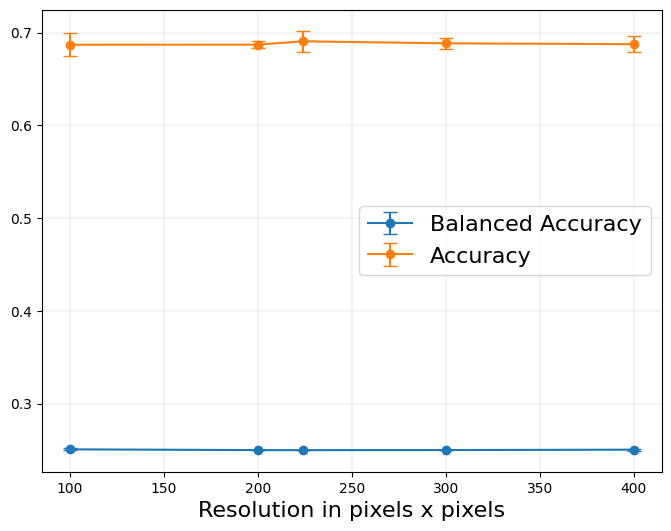

In [11]:
plt.figure(figsize=(8, 6))

aucs_at_means = []
aucs_at_stds = []
aucs_ef_means = []
aucs_ef_stds = []
aucs_in_means = []
aucs_in_stds = []
aucs_nf_means = []
aucs_nf_stds = []
baccs_means = []
baccs_stds = []
accs_means = []
accs_stds = []


for evals_per_size in evaluations.values():
    aucs_at = []
    aucs_ef = []
    aucs_in = []
    aucs_nf = []
    baccs = []
    accs = []
    
    for eval in evals_per_size:
        aucs_at.append(eval[0][0])
        aucs_ef.append(eval[0][1])
        aucs_in.append(eval[0][2])
        aucs_nf.append(eval[0][3])
        baccs.append(eval[1])
        accs.append(eval[2])

    aucs_at_means.append(np.mean(aucs_at))
    aucs_at_stds.append(np.std(aucs_at))
    aucs_ef_means.append(np.mean(aucs_ef))
    aucs_ef_stds.append(np.std(aucs_ef))
    aucs_in_means.append(np.mean(aucs_in))
    aucs_in_stds.append(np.std(aucs_in))
    aucs_nf_means.append(np.mean(aucs_nf))
    aucs_nf_stds.append(np.std(aucs_nf))
    baccs_means.append(np.mean(baccs))
    baccs_stds.append(np.std(baccs))
    accs_means.append(np.mean(accs))
    accs_stds.append(np.std(accs))

x_values = [100, 200, 224, 300, 400] #, 500, 768, 1024]

font_size = 16

plt.errorbar(x_values, baccs_means, yerr=baccs_stds, label='Balanced Accuracy', fmt='-o', capsize=5)
plt.errorbar(x_values, accs_means, yerr=accs_stds, label='Accuracy', fmt='-o', capsize=5)

# plt.errorbar(x_values, aucs_at_means, yerr=aucs_at_stds, label='Atelectasis', fmt='-o', capsize=5)
# plt.errorbar(x_values, aucs_ef_means, yerr=aucs_ef_stds, label='Effusion', fmt='-o', capsize=5)
# plt.errorbar(x_values, aucs_in_means, yerr=aucs_in_stds, label='Infiltration', fmt='-o', capsize=5)
# plt.errorbar(x_values, aucs_nf_means, yerr=aucs_nf_stds, label='No Finding', fmt='-o', capsize=5)

plt.xlabel("Resolution in pixels x pixels", fontsize=font_size)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.legend(fontsize=font_size, loc="center right")

plt.savefig("evals/chestxray8/resolution_accBaccs_10000_samples_5runs_onlyfirst5.pdf", bbox_inches='tight', pad_inches=0)

plt.show()